TBC

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str})
print(train_set_orig.shape)
train_set_orig.head()

(588758, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str})
print(test_set.shape)
test_set.head()

(32995, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,0.008458,2
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,0.050831,2


### Map `customer_id` and `article_id` to indices

Test set doesn't include anyone not in training set

In [9]:
unique_customers_df = train_set_orig[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9208

In [10]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
#     usecols=['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [11]:
articles_df['product_group_no'] = articles_df['product_group_name'].copy()

In [12]:
CATEGORICAL_FEATURES = [
    'product_code', 
    'product_type_no', 
    'product_group_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id', 
    'perceived_colour_master_id', 
    'department_no', 
    'index_code', 
    'index_group_no', 
    'section_no', 
    'garment_group_no'
]

In [13]:
for cat in CATEGORICAL_FEATURES:
    print(cat)
    print(articles_df[cat].nunique())
    print('\n')

product_code
47224


product_type_no
132


product_group_no
19


graphical_appearance_no
30


colour_group_code
50


perceived_colour_value_id
8


perceived_colour_master_id
20


department_no
299


index_code
10


index_group_no
5


section_no
57


garment_group_no
21




In [14]:
cat_code_to_indices = {}

for cat in CATEGORICAL_FEATURES:
    cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(articles_df[cat].unique())).items()}

In [15]:
for cat in CATEGORICAL_FEATURES:
    articles_df[cat] = articles_df[cat].map(cat_code_to_indices[cat])

In [16]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0108775015,0,Strap top,0,Vest top,Garment Upper body,0,Solid,0,Black,0,Dark,0,Black,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
1,0108775044,0,Strap top,0,Vest top,Garment Upper body,0,Solid,1,White,1,Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
2,0108775051,0,Strap top (1),0,Vest top,Garment Upper body,1,Stripe,2,Off White,2,Dusty Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
3,0110065001,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,0,Black,0,Dark,0,Black,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1
4,0110065002,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,1,White,1,Light,1,White,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1


In [17]:
article_id_to_idx = dict(
    zip(
        articles_df['article_id'],
        articles_df.index
    )
)

In [18]:
articles_df['article_id_idx'] = articles_df['article_id'].map(article_id_to_idx)

In [19]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)
train_set_orig['article_id_idx'] = train_set_orig['article_id'].map(article_id_to_idx)

train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0,10520
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1,1,36302
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1,1,8963
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2,2,41390


Merge article features

In [20]:
train_set_orig = train_set_orig.merge(
    articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], 
    on='article_id_idx', 
    how='inner'
)

In [21]:
train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
2,2018-10-26,8256c9d0a398717ab5f575acfa5184a11ab1a1e89f7fbc...,0663713001,0.048288,1,2480,40179,16361,65,1,0,0,0,0,47,1,0,1,1
3,2018-11-02,b333b5b934a0a54154ec46a352ba16a3e0fb7815cb46dc...,0663713001,0.050831,2,3856,40179,16361,65,1,0,0,0,0,47,1,0,1,1
4,2018-12-09,6cebb7f0bf845b15e8926474096ce615874ec23e7fb59e...,0663713001,0.050831,2,2087,40179,16361,65,1,0,0,0,0,47,1,0,1,1


In [22]:
train_set_orig.drop(columns=['price', 'sales_channel_id'], inplace=True)

### Create development set

In [23]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [24]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [25]:
train_set_orig[train_set_orig['t_dat'] < endm1]['customer_id'].nunique()

9148

In [26]:
train_set_orig[train_set_orig['t_dat'] >= endm1]['customer_id'].nunique()

1998

In [27]:
# Remove customers from dev set who are not in the new training set
customers_to_remove = (
    set(train_set_orig[train_set_orig['t_dat'] >= endm1]['customer_id']) - 
    set(train_set_orig[train_set_orig['t_dat'] < endm1]['customer_id'])
)

In [28]:
len(customers_to_remove)

60

In [29]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.shape, dev_set.shape

((580395, 17), (8363, 17))

In [30]:
dev_set = dev_set.copy()[~dev_set['customer_id'].isin(customers_to_remove)]
print(dev_set.shape)
dev_set.head()

(8131, 17)


,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
771,2020-09-07,6640b7aa1645aefed9daf069304f20b29a3b000f1851dc...,0579541001,1267,18586,6656,34,0,0,0,0,0,227,0,0,32,9
772,2020-09-09,32df71b976afea7a5dbab3c3e3a5f741a6e1c73400322a...,0579541001,6508,18586,6656,34,0,0,0,0,0,227,0,0,32,9
773,2020-09-09,99153b037284ccb2ac48942ba5fb4a518dae90c425976c...,0579541001,3516,18586,6656,34,0,0,0,0,0,227,0,0,32,9
774,2020-09-10,a571ce8a653c7e052b631d33edd97ba12654b20c174de7...,0579541001,6717,18586,6656,34,0,0,0,0,0,227,0,0,32,9
775,2020-09-13,2f87bff502f2a401f85ed3cb945a85f5cf5019b776d735...,0579541001,764,18586,6656,34,0,0,0,0,0,227,0,0,32,9


In [31]:
dev_set_by_customer = dev_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
dev_set_by_customer.head()

,customer_id,article_id_idx
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[102443]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[71167, 72000, 16023]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[100645, 100645, 100648]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[103885]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[3091, 49553, 49553, 99182, 99182, 95789, 9578..."


In [32]:
customer_id_idx_ordered = dev_set_by_customer['customer_id'].map(customer_id_to_idx).tolist()

In [33]:
dev_actuals = dev_set_by_customer['article_id_idx'].to_list()

### Explore transactions

In [34]:
train_set.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
2,2018-10-26,8256c9d0a398717ab5f575acfa5184a11ab1a1e89f7fbc...,0663713001,2480,40179,16361,65,1,0,0,0,0,47,1,0,1,1
3,2018-11-02,b333b5b934a0a54154ec46a352ba16a3e0fb7815cb46dc...,0663713001,3856,40179,16361,65,1,0,0,0,0,47,1,0,1,1
4,2018-12-09,6cebb7f0bf845b15e8926474096ce615874ec23e7fb59e...,0663713001,2087,40179,16361,65,1,0,0,0,0,47,1,0,1,1


In [35]:
len(article_id_to_idx)

105542

In [36]:
train_set['article_id_idx'].nunique()

60777

In [37]:
train_set['article_id_idx'].nunique() / len(article_id_to_idx)

0.5758560573042012

Only about half of all articles are bought

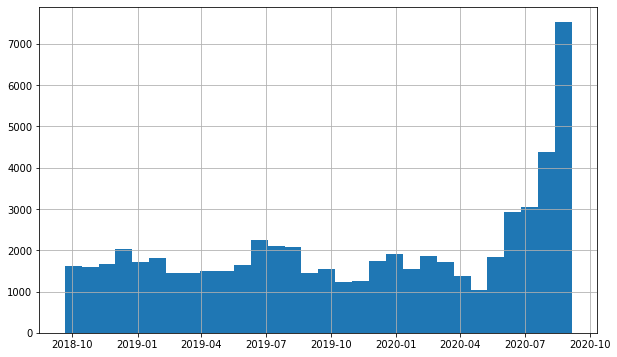

In [38]:
# Latest recorded transaction for each item
plt.figure(figsize=(10, 6))
train_set.groupby('article_id_idx')['t_dat'].max().hist(bins=30)
plt.show()

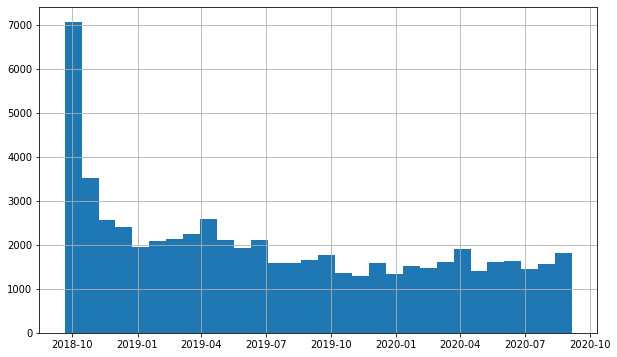

In [39]:
# First recorded transaction for each item
plt.figure(figsize=(10, 6))
train_set.groupby('article_id_idx')['t_dat'].min().hist(bins=30)
plt.show()

First chart suggests items may be removed from the catalog over time

Only include articles bought after 2020-01:

In [40]:
article_id_idx_to_keep = train_set[train_set['t_dat'] > '2020-01-01']['article_id_idx'].unique()

In [41]:
print(train_set.shape)
train_set = train_set.copy()[train_set['article_id_idx'].isin(article_id_idx_to_keep)]
print(train_set.shape)

(580395, 17)
(386503, 17)


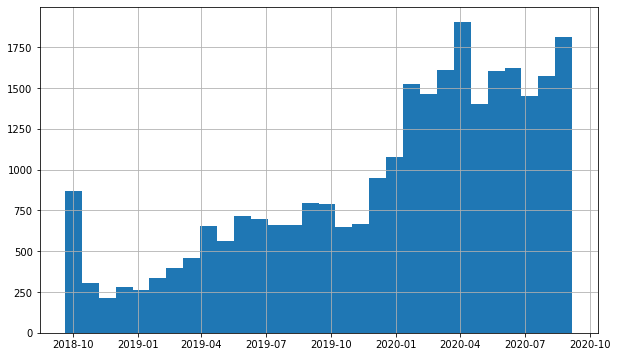

In [42]:
# First recorded transaction for each item
plt.figure(figsize=(10, 6))
train_set.groupby('article_id_idx')['t_dat'].min().hist(bins=30)
plt.show()

Can see that even though we restrict items to after 2020 some were available before then

In [43]:
(train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).head(12)

article_id_idx
53892    0.002124
53893    0.001250
1713     0.001175
24837    0.001164
70221    0.001141
3091     0.001087
42626    0.000981
24836    0.000962
1714     0.000906
67522    0.000906
58491    0.000887
2236     0.000877
Name: customer_id, dtype: float64

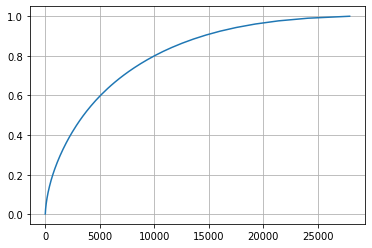

In [44]:
plt.plot((train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).cumsum().values)
plt.grid()
plt.show()

Top 10,000 most popular items account for ~80% of transactions

### Format data

Since all the users in the test said are included in training we utilise the full training set.

In [45]:
train_set.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
95,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,3,14832,5169,5,0,3,7,2,3,70,3,2,27,9
96,2018-11-11,250f3b498d9db02c2e63ff0a51d8891b0ae77e2bdf62e0...,0564358010,462,14832,5169,5,0,3,7,2,3,70,3,2,27,9
97,2018-11-23,093d9f68df61795d0e5193cd6e08d6f2c02b3054161a7f...,0564358010,2136,14832,5169,5,0,3,7,2,3,70,3,2,27,9
98,2018-11-26,32063e800a552f2feb957c4e5b442e134273db2eb3af5b...,0564358010,2614,14832,5169,5,0,3,7,2,3,70,3,2,27,9
99,2019-08-14,9570fb7ef5d4f30e34473c18bb6630b28df1f0933bed6c...,0564358010,3209,14832,5169,5,0,3,7,2,3,70,3,2,27,9


- Keep distinct purchases only
- Discard date, price and channel columns

In [46]:
endm1

Timestamp('2020-09-07 00:00:00')

In [47]:
# train_set = train_set.copy()[train_set['t_dat'] > endm1 - datetime.timedelta(days=7*52)]

In [48]:
train_set_processed = train_set.copy().drop(columns=['t_dat']).drop_duplicates()
train_set_processed.shape

(323296, 16)

In [49]:
train_set_processed.head()

,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
95,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,3,14832,5169,5,0,3,7,2,3,70,3,2,27,9
96,250f3b498d9db02c2e63ff0a51d8891b0ae77e2bdf62e0...,0564358010,462,14832,5169,5,0,3,7,2,3,70,3,2,27,9
97,093d9f68df61795d0e5193cd6e08d6f2c02b3054161a7f...,0564358010,2136,14832,5169,5,0,3,7,2,3,70,3,2,27,9
98,32063e800a552f2feb957c4e5b442e134273db2eb3af5b...,0564358010,2614,14832,5169,5,0,3,7,2,3,70,3,2,27,9
99,9570fb7ef5d4f30e34473c18bb6630b28df1f0933bed6c...,0564358010,3209,14832,5169,5,0,3,7,2,3,70,3,2,27,9


For each customer sample up to X non-purchased items to use as negative samples

In [50]:
purchases_by_customer_id_idx = train_set_processed.groupby('customer_id_idx')['article_id_idx'].apply(lambda x: list(x)).reset_index()
purchases_by_customer_id_idx.head()

,customer_id_idx,article_id_idx
0,0,"[1469, 59458, 60253, 60259, 91841, 93585, 9215..."
1,1,"[15137, 50471, 62125, 43421, 43952, 32311, 648..."
2,2,"[176, 2252, 9773, 28971, 12589, 12585, 32742, ..."
3,3,"[14832, 17669, 14240, 40411, 2255, 2252, 14246..."
4,4,"[74, 60342, 1569, 67, 17383, 55777, 47592, 648..."


In [51]:
def negative_samples(excl):
    samples = set(np.random.choice(len(article_id_to_idx), replace=False, size=1000))
    neg_samples = samples - set(excl)
    return list(neg_samples)

In [52]:
# negative_samples(purchases_by_customer_id_idx.iloc[0]['article_id_idx'])

In [53]:
%%time
purchases_by_customer_id_idx['negative_samples'] = purchases_by_customer_id_idx['article_id_idx'].apply(negative_samples)

CPU times: user 14.6 s, sys: 349 ms, total: 14.9 s
Wall time: 14.9 s


In [54]:
purchases_by_customer_id_idx.head()

,customer_id_idx,article_id_idx,negative_samples
0,0,"[1469, 59458, 60253, 60259, 91841, 93585, 9215...","[98305, 59395, 14339, 104452, 71687, 49160, 73..."
1,1,"[15137, 50471, 62125, 43421, 43952, 32311, 648...","[79872, 98315, 55310, 8210, 43028, 53269, 6760..."
2,2,"[176, 2252, 9773, 28971, 12589, 12585, 32742, ...","[53250, 38914, 26628, 2054, 28679, 102407, 962..."
3,3,"[14832, 17669, 14240, 40411, 2255, 2252, 14246...","[77825, 6146, 12289, 51206, 73736, 43017, 6759..."
4,4,"[74, 60342, 1569, 67, 17383, 55777, 47592, 648...","[51200, 79873, 10243, 47109, 83978, 102411, 12..."


In [55]:
purchases_by_customer_id_idx['negative_samples'].apply(len).value_counts()

1000    6758
999     1704
998      435
997      103
996       32
995       10
994        6
993        4
Name: negative_samples, dtype: int64

In [56]:
negative_samples_df = purchases_by_customer_id_idx[['customer_id_idx', 'negative_samples']].explode('negative_samples')
negative_samples_df.head()

,customer_id_idx,negative_samples
0,0,98305
0,0,59395
0,0,14339
0,0,104452
0,0,71687


In [57]:
negative_samples_df.isnull().sum()

customer_id_idx     0
negative_samples    0
dtype: int64

In [58]:
negative_samples_df.dropna(subset=['negative_samples'], inplace=True)

In [59]:
negative_samples_df.rename(columns={'negative_samples': 'article_id_idx'}, inplace=True)
negative_samples_df['purchased'] = 0

In [60]:
print(negative_samples_df.shape)
negative_samples_df.head()

(9048875, 3)


,customer_id_idx,article_id_idx,purchased
0,0,98305,0
0,0,59395,0
0,0,14339,0
0,0,104452,0
0,0,71687,0


In [61]:
negative_samples_df = negative_samples_df.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on='article_id_idx')
print(negative_samples_df.shape)
negative_samples_df.head()

(9048875, 15)


,customer_id_idx,article_id_idx,purchased,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,0,98305,0,42753,25,11,18,16,2,5,272,7,4,52,14
1,134,98305,0,42753,25,11,18,16,2,5,272,7,4,52,14
2,175,98305,0,42753,25,11,18,16,2,5,272,7,4,52,14
3,352,98305,0,42753,25,11,18,16,2,5,272,7,4,52,14
4,508,98305,0,42753,25,11,18,16,2,5,272,7,4,52,14


In [62]:
positive_samples_df = train_set_processed.copy().drop(columns=['customer_id', 'article_id'])
positive_samples_df['purchased'] = 1

print(positive_samples_df.shape)
positive_samples_df.head()

(323296, 15)


,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,purchased
95,3,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
96,462,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
97,2136,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
98,2614,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
99,3209,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1


In [63]:
training_data_full = positive_samples_df.append(negative_samples_df)
training_data_full.shape

/var/folders/y7/s4mqr2gn1xs617jmcj6fc_ph0000gn/T/ipykernel_71597/1159554460.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  training_data_full = positive_samples_df.append(negative_samples_df)


(9372171, 15)

In [64]:
training_data_full['purchased'].mean()

0.034495315973214744

In [65]:
training_data_full.head()

,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,purchased
95,3,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
96,462,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
97,2136,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
98,2614,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1
99,3209,14832,5169,5,0,3,7,2,3,70,3,2,27,9,1


Create another dev split to measure classification loss during training

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
training_data_full, dev_data_full = train_test_split(training_data_full, test_size=0.3)

In [68]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        self.article_id_idx = df['article_id_idx'].values
        self.product_code = df['product_code'].values
        self.product_type_no = df['product_type_no'].values
        self.product_group_no = df['product_group_no'].values
        self.graphical_appearance_no = df['graphical_appearance_no'].values
        self.colour_group_code = df['colour_group_code'].values
        self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        self.department_no = df['department_no'].values
        self.index_code = df['index_code'].values
        self.index_group_no = df['index_group_no'].values
        self.section_no = df['section_no'].values
        self.garment_group_no = df['garment_group_no'].values
        self.purchased = df['purchased'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            self.product_code[idx],
            self.product_type_no[idx],
            self.product_group_no[idx],
            self.graphical_appearance_no[idx],
            self.colour_group_code[idx],
            self.perceived_colour_value_id[idx],
            self.perceived_colour_master_id[idx],
            self.department_no[idx],
            self.index_code[idx],
            self.index_group_no[idx],
            self.section_no[idx],
            self.garment_group_no[idx],
            self.purchased[idx]
        )

In [69]:
train_dataset = PurchasesDatasetWithArticleFeatures(training_data_full)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_data_full)

In [70]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [71]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [72]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=embedding_dim)
        self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=embedding_dim*14, out_features=1000)            

        self.fc_2 = nn.Linear(in_features=1000, out_features=500)
        
        self.fc_3 = nn.Linear(in_features=500, out_features=250)
        
        self.fc_4 = nn.Linear(in_features=250, out_features=1)
        
        # Activation functions
        self.relu = nn.ReLU()        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        user_id, 
        item_id,
        product_code, 
        product_type_no, 
        product_group_no, 
        graphical_appearance_no, 
        colour_group_code, 
        perceived_colour_value_id, 
        perceived_colour_master_id, 
        department_no, 
        index_code, 
        index_group_no, 
        section_no, 
        garment_group_no
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        product_code_emb = self.product_code_embeddings(product_code)
        product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        department_no_emb = self.department_no_embeddings(department_no)
        index_code_emb = self.index_code_embeddings(index_code)
        index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        section_no_emb = self.section_no_embeddings(section_no)
        garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                product_code_emb,
                product_type_no_emb,
                product_group_no_emb,
                graphical_appearance_no_emb,
                colour_group_code_emb,
                perceived_colour_value_id_emb,
                perceived_colour_master_id_emb,
                department_no_emb,
                index_code_emb,
                index_group_no_emb,
                section_no_emb,
                garment_group_no_emb
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_4(x)
        x = self.sigmoid(x)

        return x

In [73]:
fashion_rec_v2 = FashionRecV2(embedding_dim=50)

In [74]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 50)
  (item_embeddings): Embedding(105542, 50)
  (product_code_embeddings): Embedding(47224, 50)
  (product_type_no_embeddings): Embedding(132, 50)
  (product_group_no_embeddings): Embedding(19, 50)
  (graphical_appearance_no_embeddings): Embedding(30, 50)
  (colour_group_code_embeddings): Embedding(50, 50)
  (perceived_colour_value_id_embeddings): Embedding(8, 50)
  (perceived_colour_master_id_embeddings): Embedding(20, 50)
  (department_no_embeddings): Embedding(299, 50)
  (index_code_embeddings): Embedding(10, 50)
  (index_group_no_embeddings): Embedding(5, 50)
  (section_no_embeddings): Embedding(57, 50)
  (garment_group_no_embeddings): Embedding(21, 50)
  (fc_1): Linear(in_features=700, out_features=1000, bias=True)
  (fc_2): Linear(in_features=1000, out_features=500, bias=True)
  (fc_3): Linear(in_features=500, out_features=250, bias=True)
  (fc_4): Linear(in_features=250, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): 

In [75]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [76]:
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.001)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [77]:
criterion = nn.BCELoss()

In [78]:
MAX_EPOCHS = 3
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = data
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no
        )

        loss = criterion(pred.flatten(), label.float())

        loss.backward()  
        
        optimizer.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = data
        
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = data
        
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

  3%|███▋                                                                                                                                    | 86/3204 [00:23<13:59,  3.72it/s]


KeyboardInterrupt: 

### Test set evaluation

In [190]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

In [268]:
test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79..."


In [269]:
test_set.shape

(32995, 6)

In [270]:
test_set.shape[0] * 100 / len(dev_dataset) * 9 / 60

2.1266516274572993

In [271]:
training_data_full.head()

,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,purchased
513448,4510,62123,25600,24,0,2,1,1,17,62,0,0,24,3,1
385048,3881,71087,29480,5,0,0,0,0,0,227,0,0,32,9,1
255703,3890,47915,19539,22,10,0,0,0,0,21,1,0,14,8,1
274433,2492,78976,33231,25,11,0,33,4,9,253,0,0,21,16,0
424014,320,418,124,14,0,3,5,2,3,0,0,0,0,0,1


In [272]:
top100_items = (train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).head(1000).index.tolist()

In [273]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.drop(columns='customer_id', inplace=True)
test_data.head()

,customer_id_idx
0,0
1,4003
2,238
3,3419
4,7876


In [274]:
test_data['join_key'] = 1

In [275]:
top100_items_df = pd.DataFrame({'article_id_idx': top100_items})
top100_items_df['join_key'] = 1
top100_items_df.head()

,article_id_idx,join_key
0,53892,1
1,53893,1
2,1713,1
3,24837,1
4,70221,1


In [276]:
test_data = test_data.merge(top100_items_df, on='join_key').drop('join_key', axis=1)

In [277]:
test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'])

In [278]:
test_data['purchased'] = 999

In [279]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

In [280]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [281]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = data

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            label.to(device)
        )    

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no
        )
        
        test_predictions += pred.flatten().tolist()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1125/1125 [05:47<00:00,  3.24it/s]


In [282]:
len(test_predictions)

9208000

In [283]:
len(test_dataset)

9208000

In [284]:
test_data['prediction'] = test_predictions

In [285]:
test_data.sort_values(['customer_id_idx', 'prediction'], ascending=False, inplace=True)

In [286]:
test_data_top12 = test_data.groupby('customer_id_idx').head(12).groupby('customer_id_idx').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'predictions'})
test_data_top12

,customer_id_idx,predictions
0,0,"[2236, 73660, 22639, 86195, 88302, 80935, 9158..."
1,1,"[2236, 73660, 22639, 88302, 86195, 80935, 9158..."
2,2,"[2236, 73660, 22639, 88302, 91582, 86195, 8093..."
3,3,"[2236, 88302, 73660, 22639, 91582, 86195, 8093..."
4,4,"[2236, 73660, 22639, 86195, 80935, 88302, 9158..."
...,...,...
9203,9203,"[2236, 73660, 22639, 88302, 91582, 86195, 8093..."
9204,9204,"[2236, 73660, 22639, 88302, 91582, 86195, 8093..."
9205,9205,"[2236, 73660, 22639, 88302, 86195, 91582, 8093..."
9206,9206,"[2236, 73660, 22639, 88302, 91582, 86195, 8093..."


In [287]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

In [288]:
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876


In [289]:
test_set_by_customer = test_set_by_customer.merge(test_data_top12, on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0,"[2236, 73660, 22639, 86195, 88302, 80935, 9158..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003,"[2236, 73660, 22639, 88302, 86195, 80935, 9158..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238,"[2236, 73660, 22639, 88302, 91582, 86195, 8093..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419,"[2236, 73660, 22639, 86195, 80935, 63471, 6480..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876,"[2236, 73660, 22639, 86195, 88302, 80935, 9158..."


In [290]:
predictions = test_set_by_customer['predictions'].to_list()

In [291]:
actuals = test_set_by_customer['article_id_idx'].to_list()

In [292]:
mapk(actuals, predictions, k=12)

0.0002395478250712829

CF doesn't do better than simple heuristic (top 12 most popular). Possibly explains why earlier attempts at training embeddings failed.